In [1]:
# Draw the simulation environmnt
# Draw sequencing and reach-avoid task
# dynamic model 
# draw a success rate table

In [1]:
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
import gym
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import Dataset
import sys
from collect_skill_trajectories import get_all_goal_value, from_real_dict_to_vector, ZONE_OBS_DIM
from stable_baselines3 import PPO
from train_dynamics import VFDynamics, VFDynamicsMLP
import rtamt
import time
#from gym.wrappers import RecordVideo
from gym.wrappers.monitor import video_recorder as VR
from random_shooting import RandomShootingController, MPController
import math
from tqdm import tqdm
sys.path.append("/app/vfstl/src/GCRL-LTL/zones")
from envs import ZoneRandomGoalEnv
from envs.utils import get_zone_vector
from rl.traj_buffer import TrajectoryBufferDataset
import matplotlib.pyplot as plt
from PIL import Image

/opt/conda/envs/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda:1")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

def cost_fn(state):
    return torch.randn(state.size()[0])

model_path = '/app/vfstl/src/GCRL-LTL/zones/models/goal-conditioned/best_model_ppo_8'
policy_model = PPO.load(model_path, device=device)
timeout = 1000
seed = 134
seed = 135
seed = 136
env = ZoneRandomGoalEnv(
    env=gym.make('Zones-8-v1', map_seed=seed, timeout=timeout), 
    primitives_path='/app/vfstl/src/GCRL-LTL/zones/models/primitives', 
    goals_representation=get_zone_vector(),
    use_primitves=True,
    rewards=[0, 1],
    device=device,
)

CUDA is available. Training on GPU.


In [3]:
obs = env.reset()

In [4]:
rgb_array = env.render(mode='rgb_array', camera_id=1, width=1080, height=1080)

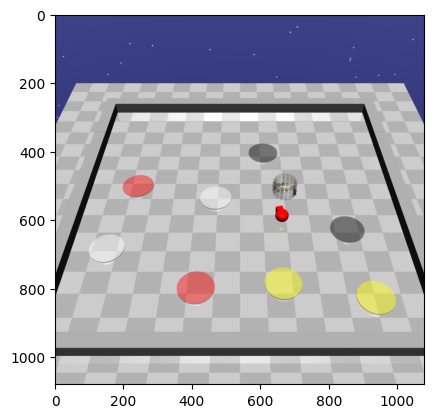

In [5]:
plt.imshow(rgb_array)

In [6]:
im = Image.fromarray(rgb_array)
im.save("/app/vfstl/src/VFSTL/data_for_paper/robot_centered.jpeg")

In [7]:
from controller_evaluator import ControllerEvaluator, plot_traj_2d, TaskSampler

In [8]:
vf_num = 4
T_horizon = 4
skill_timesteps = 100

model = VFDynamicsMLP(len(env.goals))
model.load_state_dict(torch.load("/app/vfstl/src/VFSTL/dynamic_models/test_model_20240307_085639_11"))
dynamics = VFDynamics(model.to(device), len(env.goals))

controller = RandomShootingController(skill_timesteps, policy_model, dynamics, env.goals, T_horizon, 32768, 50, device)
#controller = MPController(skill_timesteps, policy_model, dynamics, env.goals, T_horizon, 32768, 50, device)
evaluator = ControllerEvaluator(controller, env)
# s,c,r,t = evaluator.one_step_prediction(stl)
# tensor_s = torch.tensor(s, device=device)
# tensor_s = tensor_s[None, :, :]
# ro = get_env_ground_truth_robustness_value(stl_env, tensor_s, env.zones, env.zone_types)
# sequence 
# stl_spec_env = 'eventually[0,200](R0 >= 0.8 and eventually[0,200] (Y0 >= 0.8))'
# stl_spec =  'eventually[0,2](R0 >= 0.8 and eventually[0,2] ((Y0 >= 0.8) and eventually[0,2] (J0 >= 0.8)))'

# reach avoid
#stl_spec_env = 'eventually[0,200](R0 >= 0.8 and eventually[0,200] (Y0 >= 0.8))'
#stl_spec =  'not(R0 >= 0.8) until[0, 4] (Y0 >= 0.8 and (not (W0 >= 0.8) until[0, 4] (J0 >= 0.8)))'

stl_spec =  'not(Y0 >= 0.8) until[0, 2] (R0 >= 0.8 and (not (J0 >= 0.8) until[0, 2] (W0 >= 0.8)))'
distances ,contorls, reward, timesteps, traj, zones_pos, goals, robot_in_zones = evaluator.one_epoch_prediction(stl_spec)

tensor([1, 1, 2, 2, 1, 2, 1, 2], device='cuda:1')
cost
tensor(-0.0801, device='cuda:1', dtype=torch.float64,
       grad_fn=<SelectBackward0>)


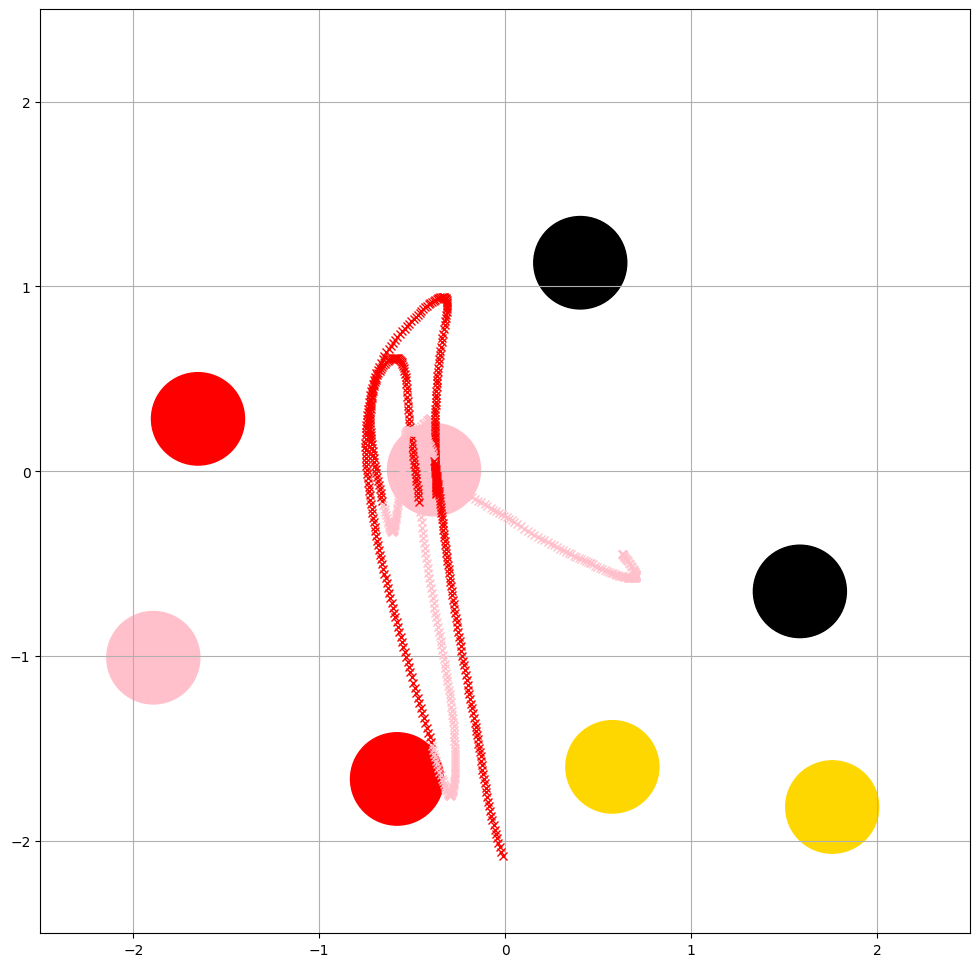

In [9]:
a = datetime.now()
plot_traj_2d(env, np.array(traj), np.array(goals), '{}_traj_{}_{}'.format(a.ctime(), stl_spec, seed))

In [15]:
a = datetime.now()

In [27]:
a.ctime()

'Mon Mar 18 19:01:19 2024'